In [7]:
# imports
import SimpleITK as sitk
import matplotlib.pyplot as plt
import time

In [3]:
# get the data
import data_load

data_loader = data_load.DataLoader()
image_data, np_array_data, data_labels = data_loader.retina()

In [4]:
print(len(image_data))
print(len(np_array_data))

884
884


In [11]:
%%capture
print(image_data[0])

In [12]:
%%capture
print(np_array_data[0])

In [14]:
#%%capture
print("poaGlaucoma: ", sum(data_labels), "  Healthy:", len(data_labels)-sum(data_labels))

poaGlaucoma:  677   Healthy: 207


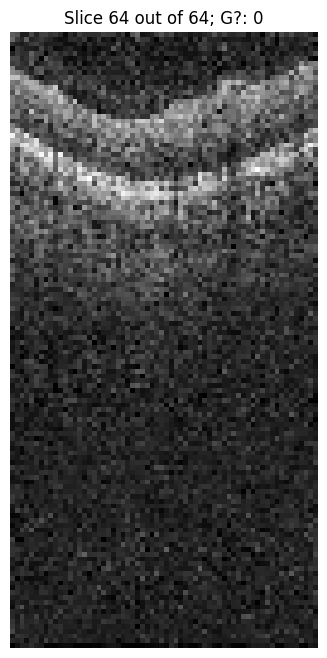

In [10]:
from IPython.display import clear_output
id = 35
array = np_array_data[id]
label = data_labels[id]

# Display axial view 
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    time.sleep(0.3)
    clear_output(wait=True)



In [ ]:
label[id]